# Sử dụng và dự đoán change rate

In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2018-12-31,157.740005,1044.959961,101.570000,1501.969971,131.089996
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003


## Change Rate = (today-yesterday)/yesterday

In [57]:
def get_cr(df, history=1):
    diff = []
    df = df.to_numpy()

    for i in range(history, len(df)):
        diff.append(df[i] - df[i-history])
        
    return np.array(diff)

In [76]:
cr = get_cr(df['AAPL'])
print(cr[1])
print(df['AAPL'].iloc[1] - df['AAPL'].iloc[0])
print(df['AAPL'].to_numpy()[1] - df['AAPL'].to_numpy()[0])

-15.729995727539062
0.17999267578125
0.17999267578125


## Tạo dữ liệu Train-test cho 1 công ty

In [59]:
def create_Xy(df, code, history=2):
    '''df has index as date
    columns are stock price of the companies
    '''
    
    
    cr = get_cr(df[code])
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        X.append( cr[row_idx-history:row_idx-1].reshape(-1) )
        
        y.append( cr[row_idx-1].reshape(-1) )
        dates.append(df.index[row_idx-1])
    X, y = np.array(X), np.array(y)

    return X, y, dates

In [82]:
code = 'AAPL'
X,y,dates = create_Xy(df, code, history=5)

In [83]:
print(X.shape)
print(y.shape)

(330, 4)
(330, 1)


In [84]:
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

## Model

In [85]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_train)

## plot prediction

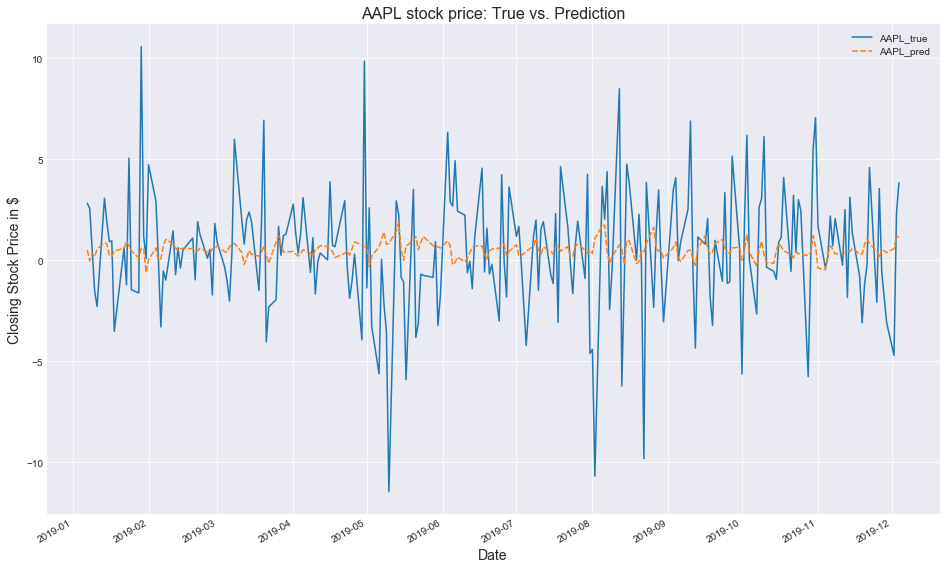

In [86]:
df_plot = pd.DataFrame({"AAPL_true": y_train.reshape(-1)[:], 'AAPL_pred': ypred.reshape(-1)[:]}, index=dates_train[:])

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title(code + ' stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

# so bad

In [103]:
from scipy.stats import pearsonr
print(X[:,1].shape)
cor, a = pearsonr(X[:,3],y.reshape(-1))
print(cor)
print(a)

(330,)
-0.30620601525965396
1.3598007279124585e-08
